# Analysis of the Probability of Randomisation


## 3x10^3 iterations of 10^3 runs varying the probability of randomisation

First we need to choose the most appropriate p_randomisation for this project to get consistent,
valuable results.

Running multiple iterations of the model and varying some parameters is the best way to do this.
Here we set up the batch runner and vary the "vehicle_density", and the "p_randomisation" to see how
one effects the other.

SETUP:

In [1]:
from model import NaSchTraffic
from mesa.batchrunner import BatchRunner

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
from numpy.random import default_rng

rng = default_rng()

sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 300

generate_new = False
load_file = "data/p_rand_df_" + "20-04-2021" + ".pkl"

In [2]:
if generate_new:
    def get_average_speed(model):
        """
        Find the average speed of all the agents over the steps after equilibrium is reached.
        """
        selected_speeds = model.speed_averages[200:]    # slicing the region from 200 onwards

        return sum(selected_speeds) / len(selected_speeds)

    def get_average_density(model):
        """
        Find the average density of all the agents over the steps after equilibrium is reached.
        """
        selected_densities = model.densities[200:]

        return sum(selected_densities) / len(selected_densities)

    def get_average_flow(model):
        """
        Find the average flow of all the agents over the steps after equilibrium is reached.
        """
        selected_flows = model.flows[200:]

        return float(sum(selected_flows)) / len(selected_flows)

    model_reporters_pr={
        "Averaged_Speed": get_average_speed,
        "Averaged_Density": get_average_density,
        "Averaged_Flow": get_average_flow,
    }

    density_distro = rng.uniform(low=0.01, high=0.3, size=60)
    p_distro = np.linspace(0.1, 0.6, 12)

    fixed_params_pr = {"height": 1, "width": 200, "general_max_speed": 5}
    variable_params_pr = { "vehicle_density": density_distro, "p_randomisation": p_distro}

    param_sweep_pr = BatchRunner(NaSchTraffic,
                              variable_parameters=variable_params_pr, fixed_parameters=fixed_params_pr,
                              iterations=4,
                              max_steps=800,
                              model_reporters=model_reporters_pr,
                              display_progress=True)

    print("Running " + str(4*12*60) +" model iterations:")
    param_sweep_pr.run_all()

To visualise this the data is put into a dataframe for plotting.
In the case that the data has already been generated we can load it
from a file rather than run the model again.

In [3]:
if generate_new:
    df_pr = param_sweep_pr.get_model_vars_dataframe()
    df_pr_sorted = df_pr.sort_values('Averaged_Density')

    # SAVE TO FILE
    time_str = time.strftime("%y%m%d_%H%M")
    df_pr_sorted.to_pickle("data/p_rand_df_" + time_str + ".pkl")
else:
    # LOAD FROM FILE
    df_pr_sorted = pd.read_pickle(load_file)

df_pr_sorted.head()

,vehicle_density,p_randomisation,Run,Averaged_Density,Averaged_Flow,Averaged_Speed,height,width,general_max_speed
237,0.010316,0.600000,237,0.009778,0.043333,2.839167,1,200,5
232,0.010316,0.554545,232,0.009792,0.043333,3.012500,1,200,5
228,0.010316,0.509091,228,0.009819,0.045000,3.021667,1,200,5
211,0.010316,0.281818,211,0.009833,0.046667,3.161667,1,200,5
194,0.010316,0.100000,194,0.009847,0.050000,3.224167,1,200,5


Impact of the probability of speed randomisation:

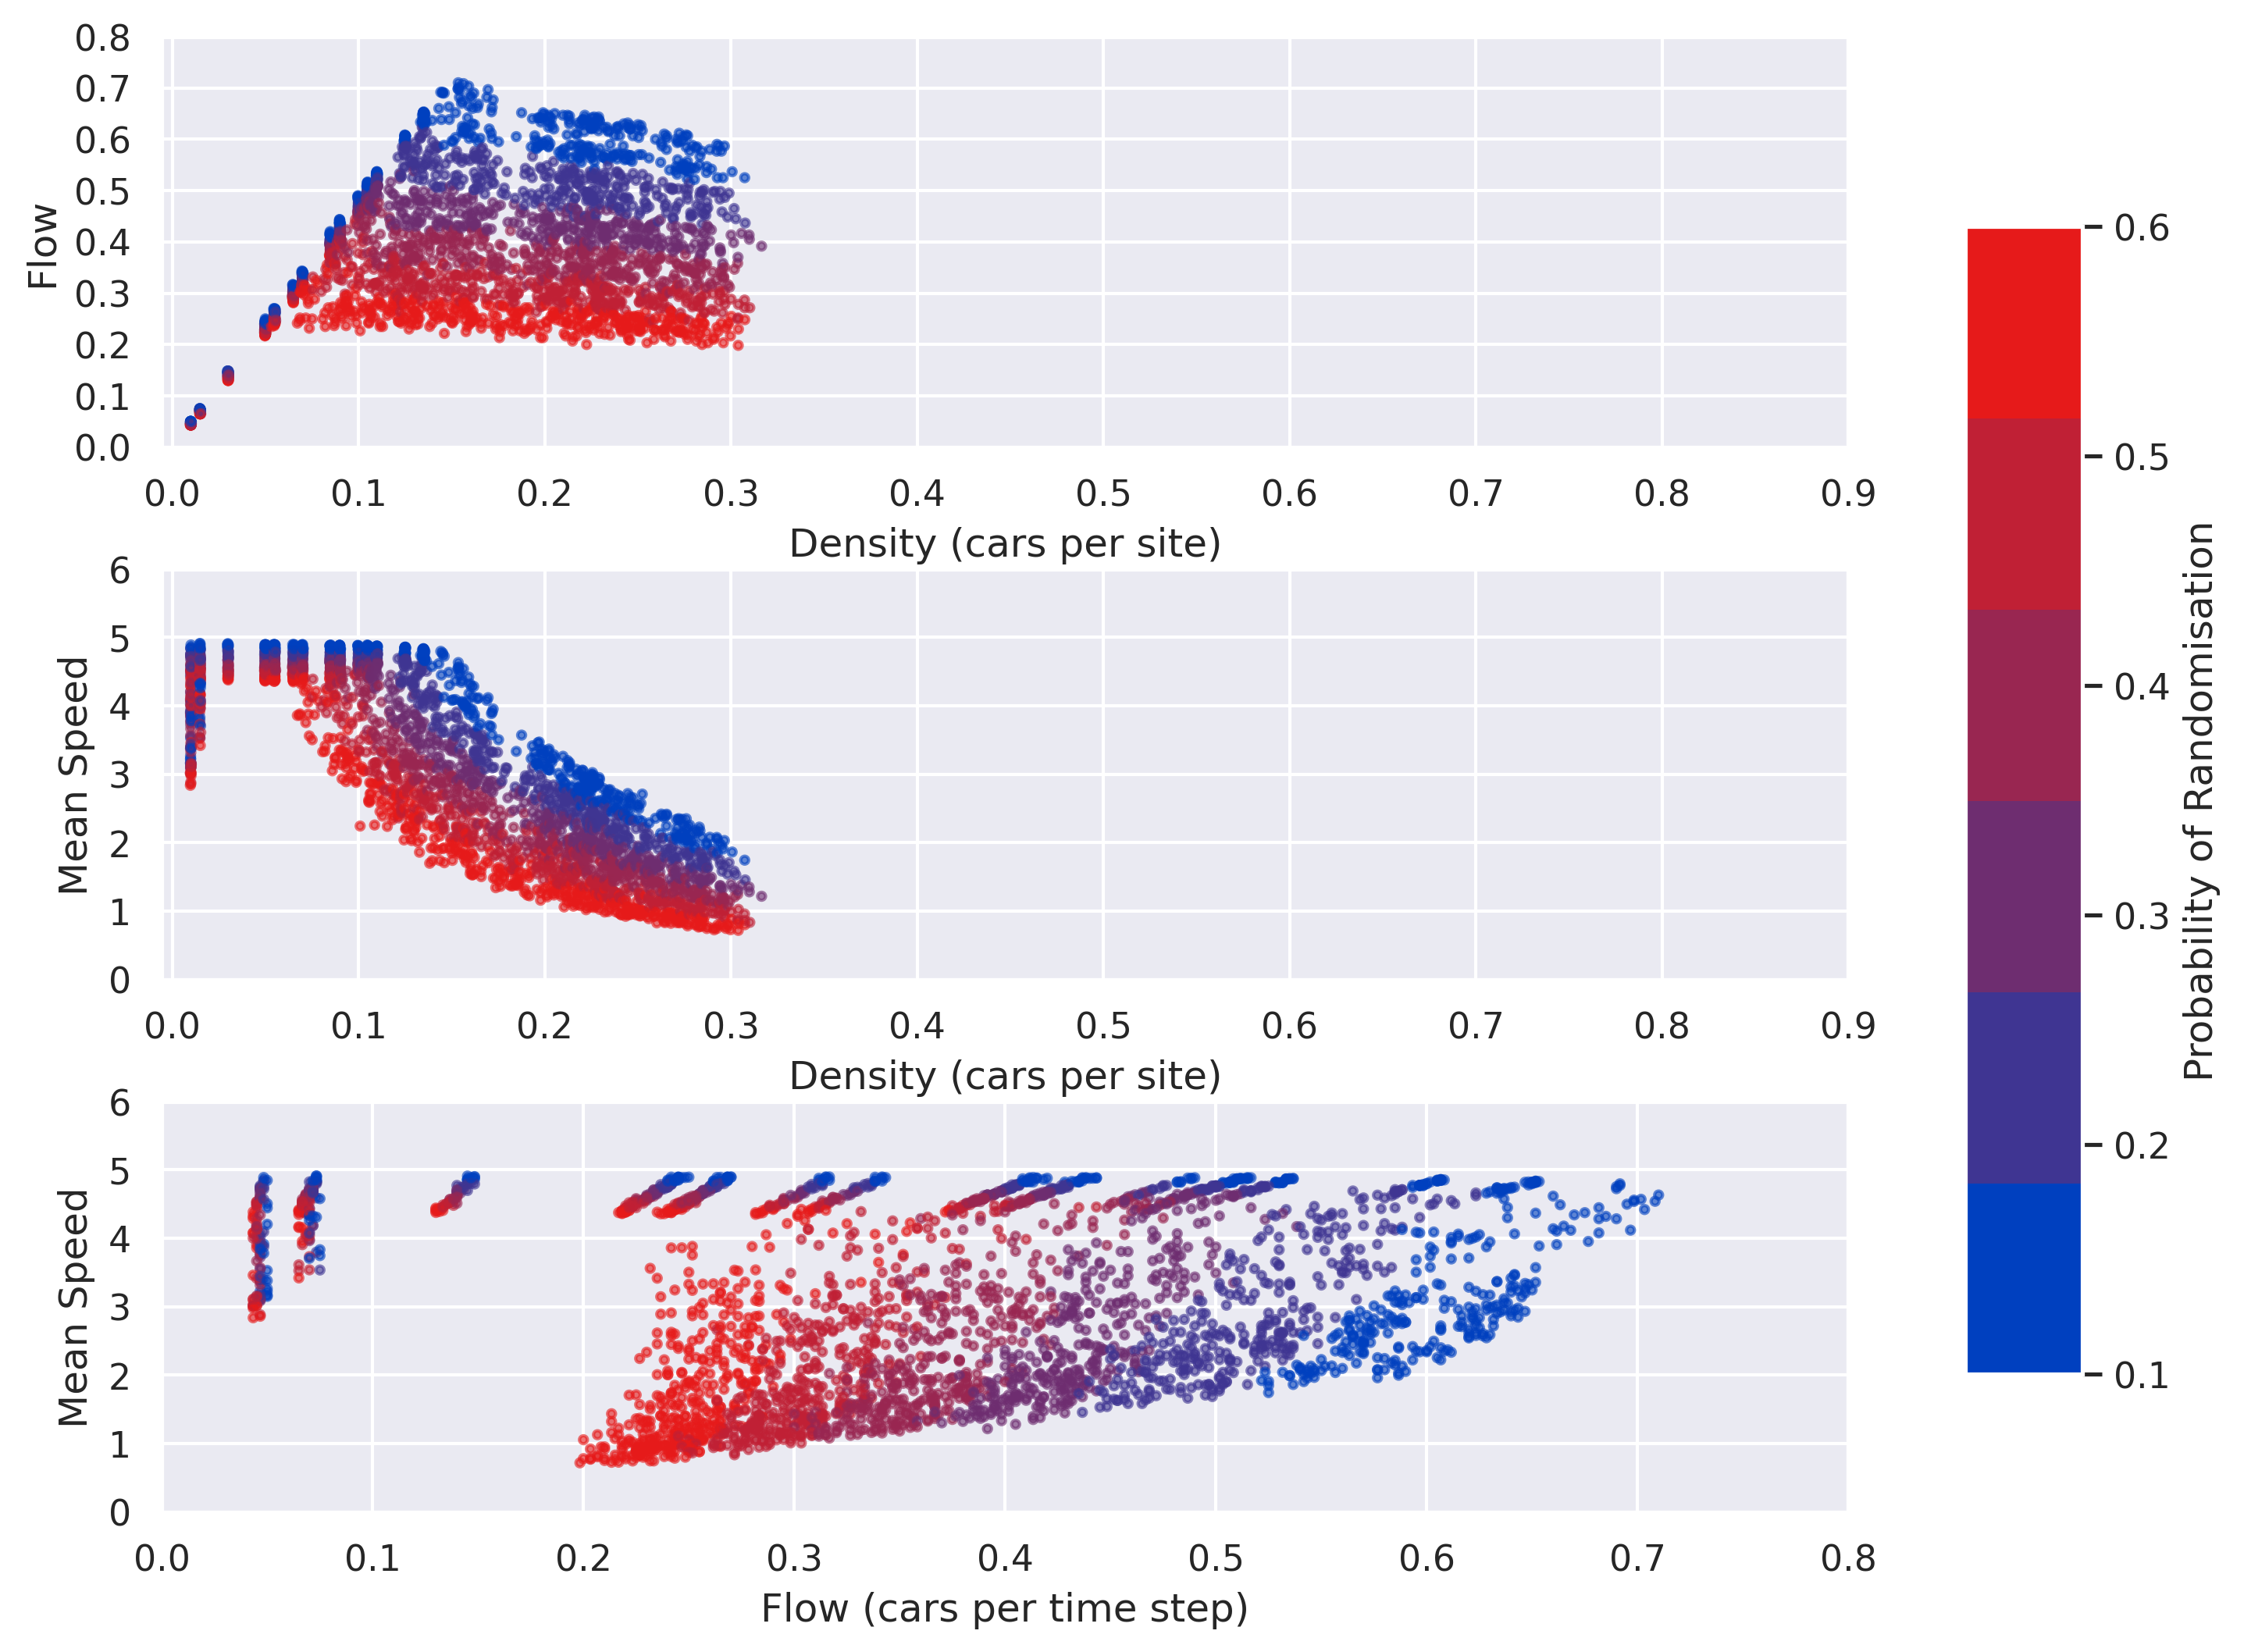

In [4]:
colors = [(0, 0.25, 0.75), (0.9, 0.1, 0.1)] # Experiment with this
cm_rand = LinearSegmentedColormap.from_list('test', colors, N=6, gamma=0.8)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.tight_layout()

ax1.scatter(df_pr_sorted.Averaged_Density, df_pr_sorted.Averaged_Flow, c=df_pr_sorted.p_randomisation, cmap=cm_rand, s=6, alpha=0.6)
ax1.set(xlabel='Density (cars per site)', ylabel='Flow')
ax1.set_xticks(np.arange(0, 1, step=0.1))
ax1.set_yticks(np.arange(0, 0.9, step=0.1))
ax1.grid(True)

ax2.scatter(df_pr_sorted.Averaged_Density, df_pr_sorted.Averaged_Speed, c=df_pr_sorted.p_randomisation, cmap=cm_rand, s=6, alpha=0.6)
ax2.set(xlabel='Density (cars per site)', ylabel='Mean Speed')
ax2.set_xticks(np.arange(0, 1, step=0.1))
ax2.set_yticks(np.arange(0, 7, step=1))
ax2.grid(True)

chart=ax3.scatter(df_pr_sorted.Averaged_Flow, df_pr_sorted.Averaged_Speed, c=df_pr_sorted.p_randomisation, cmap=cm_rand, s=6, alpha=0.6)
ax3.set(xlabel='Flow (cars per time step)', ylabel='Mean Speed')
ax3.set_xticks(np.arange(0, 0.9, step=0.1))
ax3.set_yticks(np.arange(0, 7, step=1))
ax3.grid(True)

fig.subplots_adjust(right=0.8, left=0.08)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
bar = fig.colorbar(chart, cax=cbar_ax)
bar.set_label('Probability of Randomisation')
bar.set_alpha(1)
bar.draw_all()

time_str = time.strftime("%y%m%d_%H%M")
fig.savefig("img/p_random_3000_color_scatter" + time_str + ".png")
plt.show()